In [1]:
# Basic Template
%load_ext autoreload
%autoreload 2
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
from skimage.measure import compare_psnr
import cnnbin
from cnnbin.utils import psnr


### Color image

In [2]:
sigma = 30
image_ref =imageio.imread('data/monarch.bmp')
image = image_ref+sigma * np.random.standard_normal(image_ref.shape)

binned_ref = np.mean(cnnbin.split_diagonal_rgb(image_ref),0)
binned_mean = np.mean(cnnbin.split_diagonal_rgb(image),0)

In [3]:
net = cnnbin.CNNbin(multichannel = True,depth=4, start_filts=48)
size = net.summary()


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 48, 128, 128]           1,344
         MaxPool2d-2           [-1, 48, 64, 64]               0
          DownConv-3  [[-1, 48, 64, 64], [-1, 48, 128, 128]]               0
            Conv2d-4           [-1, 48, 64, 64]          20,784
         MaxPool2d-5           [-1, 48, 32, 32]               0
          DownConv-6  [[-1, 48, 32, 32], [-1, 48, 64, 64]]               0
            Conv2d-7           [-1, 48, 32, 32]          20,784
         MaxPool2d-8           [-1, 48, 16, 16]               0
          DownConv-9  [[-1, 48, 16, 16], [-1, 48, 32, 32]]               0
           Conv2d-10           [-1, 48, 16, 16]          20,784
         DownConv-11  [[-1, 48, 16, 16], [-1, 48, 16, 16]]               0
  ConvTranspose2d-12           [-1, 48, 32, 32]           9,264
           Conv2d-13           [-1, 96, 32, 32]          

PSNR (32.2/23.4): 100%|█████| 50/50 [00:39<00:00,  1.25it/s]


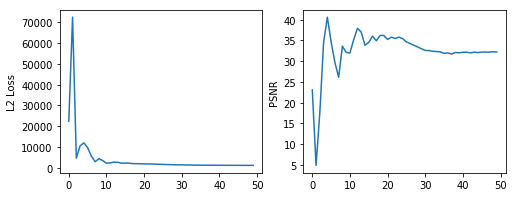

PSNR (32.5/23.4): 100%|███| 100/100 [01:19<00:00,  1.26it/s]


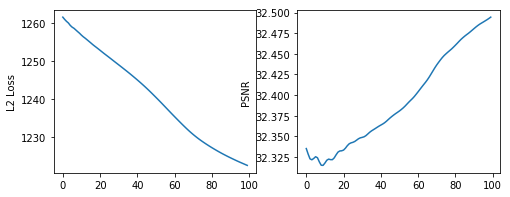

In [4]:
net.train_image(image,num_epochs= 50, learning_rate=1e-3,alpha = 0.99)
net.plot_train()
net.train_image(image,num_epochs= 100, learning_rate=1e-4,alpha = 0.99)
net.plot_train()

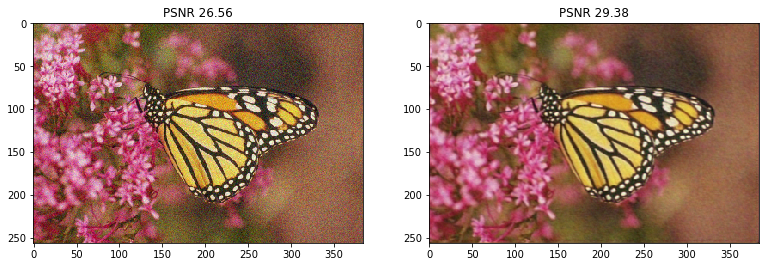

In [5]:
net.train_split(image,num_epochs= 100, learning_rate=1e-4,alpha = 0.99)
net.plot_train()

image_filter = net.filter_patch(image)

plt.figure(figsize=(13,5))
for i,im in enumerate([binned_mean,image_filter]):
    plt.subplot(1,2,1+i)    
    plt.imshow(np.clip(im/255,0,1))
    plt.title(f'PSNR {psnr(im,binned_ref):.2f}')

### Gray value image

In [ ]:
sigma = 30
image_ref = np.mean(imageio.imread('data/monarch.bmp'),2)
image = image_ref+sigma * np.random.standard_normal(image_ref.shape)

binned_ref = np.mean(cnnbin.split_diagonal(image_ref),0)
binned_mean = np.mean(cnnbin.split_diagonal(image),0)

In [28]:
block_size = (256, 256)
batch_size = 8
net = cnnbin.CNNbin(depth=4, start_filts=48,
                    block_size=block_size, batch_size=batch_size)
size = net.summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 48, 128, 128]             480
         MaxPool2d-2           [-1, 48, 64, 64]               0
          DownConv-3  [[-1, 48, 64, 64], [-1, 48, 128, 128]]               0
            Conv2d-4           [-1, 48, 64, 64]          20,784
         MaxPool2d-5           [-1, 48, 32, 32]               0
          DownConv-6  [[-1, 48, 32, 32], [-1, 48, 64, 64]]               0
            Conv2d-7           [-1, 48, 32, 32]          20,784
         MaxPool2d-8           [-1, 48, 16, 16]               0
          DownConv-9  [[-1, 48, 16, 16], [-1, 48, 32, 32]]               0
           Conv2d-10           [-1, 48, 16, 16]          20,784
         DownConv-11  [[-1, 48, 16, 16], [-1, 48, 16, 16]]               0
  ConvTranspose2d-12           [-1, 48, 32, 32]           9,264
           Conv2d-13           [-1, 96, 32, 32]          

PSNR (34.4/23.1): 100%|█████| 10/10 [00:31<00:00,  3.18s/it]


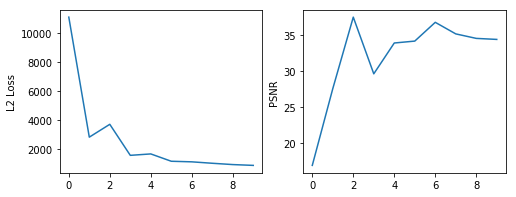

100%|███████████████████████| 12/12 [00:00<00:00, 21.24it/s]


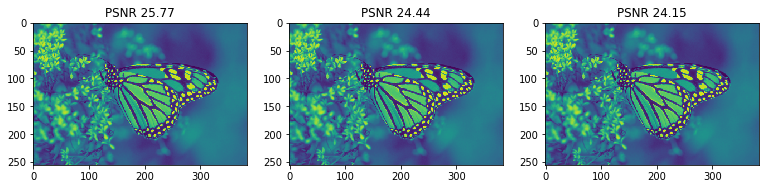

In [30]:
net.train_random(image, num_epochs=10, num_batches=2, learning_rate=1e-3, alpha=0.99)
net.plot_train()

image_filter_fuse = net.filter(image, sampling=1.01)
image_filter = net.filter_patch(image)

plt.figure(figsize=(13, 5))
for i, im in enumerate([binned_mean, image_filter, image_filter_fuse]):
    plt.subplot(1, 3, 1+i)
    plt.imshow(np.clip(binned_ref/255, 0, 1))
    plt.title(f'PSNR {psnr(im,binned_ref):.2f}')

In [2]:
sigma = 80
images_ref =[
    cnnbin.utils.pad2bin(imageio.imread(x)) for x in ['data/barbara.bmp','data/monarch.bmp','data/comic.bmp']
]
images = [x + sigma * np.random.standard_normal(x.shape) for x in images_ref]

for x in images:
    print(x.shape)

(576, 720, 3)
(512, 768, 3)
(368, 256, 3)


In [33]:
block_size = (256,256)
net = cnnbin.CNN_filter(multichannel = True, depth=4, start_filts=48, block_size = block_size)

PSNR (30.6/21.8): 100%|█████| 50/50 [03:19<00:00,  3.99s/it]


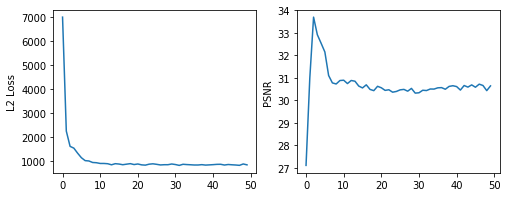

In [27]:
net.train_list(images,num_epochs= 50,batch_size = 8,num_batches = 4, lr=1e-3,alpha = 0.99)
net.plot_train()

100%|█████████████████████████| 4/4 [00:00<00:00, 18.70it/s]


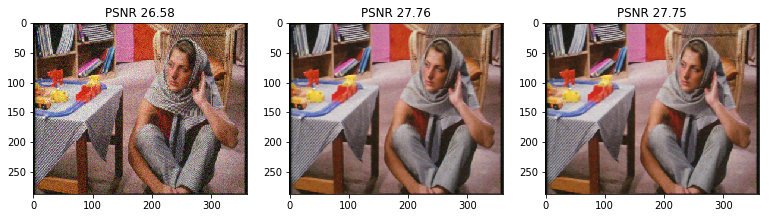

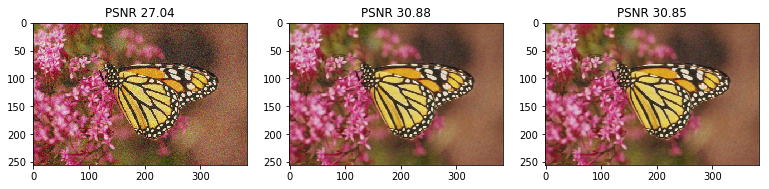

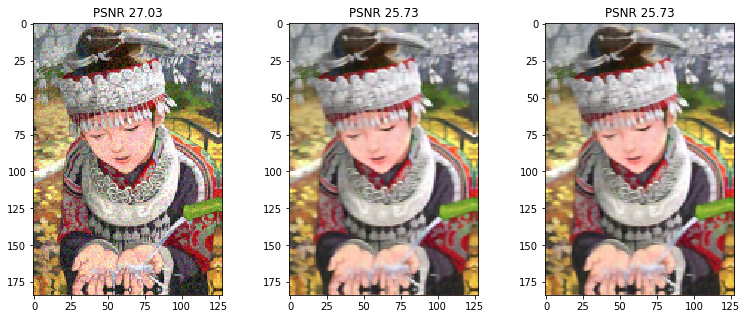

In [30]:
for img,ref in zip(images,images_ref):
    binned_ref = np.mean(cnnbin.split_diagonal_rgb(ref),0)
    binned_mean = np.mean(cnnbin.split_diagonal_rgb(img),0)

    image_filter_fuse = net.filter(img,sampling=1.1)
    image_filter = net.filter_patch(img)

    plt.figure(figsize=(13,5))
    for i,im in enumerate([binned_mean,image_filter,image_filter_fuse]):
        plt.subplot(1,3,1+i)    
        plt.imshow(np.clip(im/255,0,1))
        plt.title(f'PSNR {psnr(im,binned_ref):.2f}')